In [92]:
import re
import json
import pandas as pd
import numpy as np
import seaborn
import io
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
# just set the seed for the random number generator
np.random.seed(107)

In [93]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [94]:
prices_df = pd.read_csv("../past_data/combined_mid_prices.csv")
prices_df_0 = prices_df.iloc[:10000]
prices_df_1 = prices_df.iloc[10000:20000]
prices_df_2 = prices_df.iloc[20000:30000]

<Axes: >

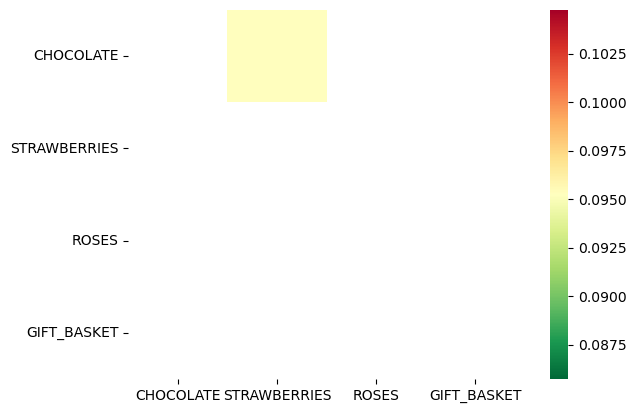

In [110]:
scores, pvalues, pairs = find_cointegrated_pairs(prices_df_0)
products = ["CHOCOLATE", "STRAWBERRIES", "ROSES", "GIFT_BASKET"]
seaborn.heatmap(pvalues, xticklabels=products, yticklabels=products, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.1)
                )

In [111]:
S1 = prices_df_0['Roses_Mid_Price']
S2 = prices_df_0['Gift_Basket_Mid_Price']

score, pvalue, _ = coint(S1, S2)
pvalue

0.3187109224795108

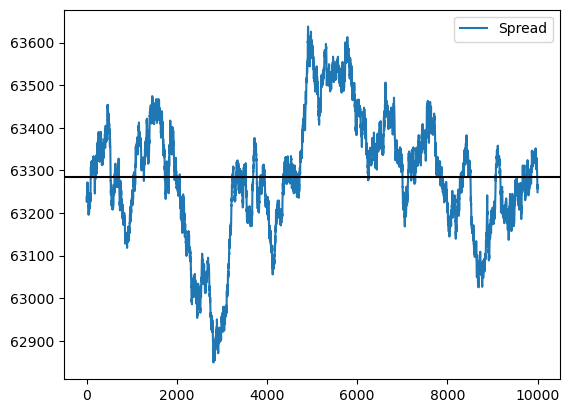

In [115]:
#spread

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['Roses_Mid_Price']
b = results.params['Roses_Mid_Price']

spread = S2 - b * S1
spread.plot()
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread'])

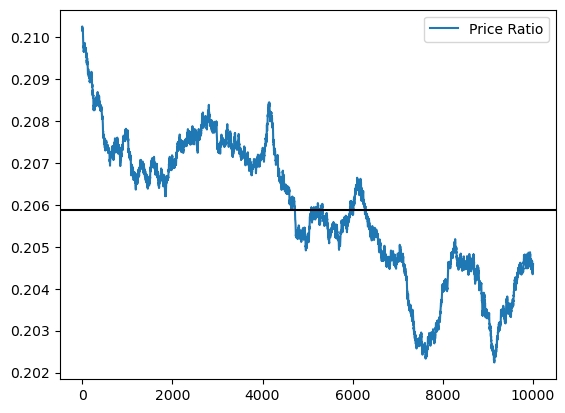

In [116]:
ratio = S1/S2
ratio.plot()
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio']);

In [117]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

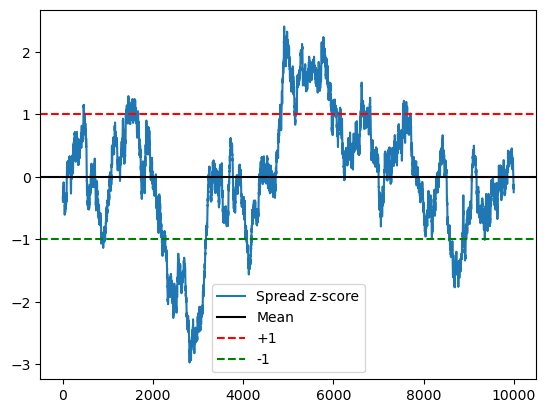

In [118]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

In [51]:
# Get the spread between the 2 stocks
# Calculate rolling beta coefficient
rolling_beta = pd.ols(y=S1, x=S2, window_type='rolling', window=30)
spread = S2 - rolling_beta.beta['x'] * S1
spread.name = 'spread'

# Get the 1 day moving average of the price spread
spread_mavg1 = pd.rolling_mean(spread, window=1)
spread_mavg1.name = 'spread 1d mavg'

# Get the 30 day moving average
spread_mavg30 = pd.rolling_mean(spread, window=30)
spread_mavg30.name = 'spread 30d mavg'

plt.plot(spread_mavg1.index, spread_mavg1.values)
plt.plot(spread_mavg30.index, spread_mavg30.values)

plt.legend(['1 Day Spread MAVG', '30 Day Spread MAVG'])

plt.ylabel('Spread')

AttributeError: module 'statsmodels.api' has no attribute 'ols'

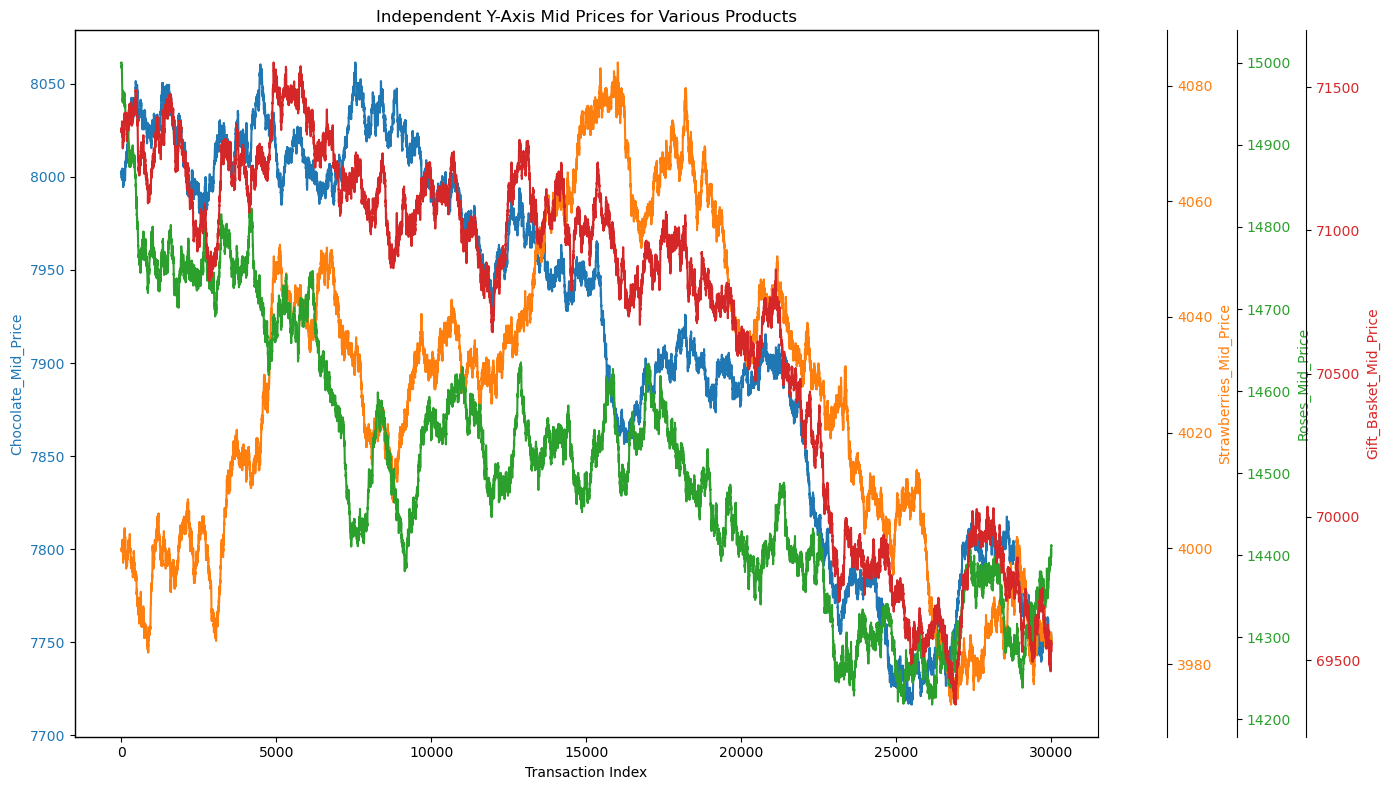

In [109]:
# Adjusting the figure to better accommodate multiple y-axes without overlap
fig, ax1 = plt.subplots(figsize=(14, 8))

# Colors for each product line
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
products = prices_df.columns

# Create axes for each line plot
axes = [ax1]
for i in range(1, 4):
    # Creating additional axes with offset for better visibility
    new_ax = ax1.twinx()
    new_ax.spines['right'].set_position(('outward', 50 * i))  # Offset each additional y-axis to the right
    axes.append(new_ax)

# Plot each line on its respective axis
for i, product in enumerate(products):
    axes[i].plot(prices_df[product], color=colors[i], label=product)
    axes[i].set_ylabel(product, color=colors[i])
    axes[i].tick_params(axis='y', labelcolor=colors[i])

# Title and x-axis
ax1.set_title('Independent Y-Axis Mid Prices for Various Products')
ax1.set_xlabel('Transaction Index')

# Improving the layout
fig.tight_layout()  # Automatically adjust subplot params to give specified padding
plt.show()
